In [9]:
import pandas as pd
import numpy as np
import torch
import optuna
import torch.nn as nn
from torchsummary import summary
from torch.nn.functional import mse_loss
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from utils_pp import replace_cell_names_with_id
%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
df_train["cell_line"]
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()

# drug_data = pd.read_pickle("../data/drug_data.pkl.compress", compression="gzip")
cell_data = pd.read_pickle("../data/cell_line_data.pkl.compress", compression="gzip")
X_train_cell, X_val_cell, y_train_cell, y_val_cell = train_test_split(cell_data, cell_data, test_size=0.2, shuffle=True)
df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
# df_train = df_train[df_train.cell_line.isin(cell_data.index)]
# df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
# cell_data = cell_data[cell_data.index.isin(pd.concat([df_train.cell_line, df_test.cell_line]))]
# print("oneil", df_train.memory_usage().sum()/1e6, df_train.shape,"\n", df_train.dtypes)
print("drug_feat", X_train_cell.memory_usage().sum()/1e6, X_train_cell.shape)
print("drug_feat", X_val_cell.memory_usage().sum()/1e6, X_val_cell.shape)
print("cell_feat", cell_data.memory_usage().sum()/1e6, cell_data.shape)


drug_feat 23.298024 (1160, 5011)
drug_feat 5.858004 (290, 5011)
cell_feat 29.111364 (1450, 5011)


In [11]:
class dataset(Dataset):
    def __init__(self, data, labels):
        self.dataset = data.to_numpy()
        self.labels = labels.to_numpy()

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]
                
train_set_cell  = dataset(X_train_cell, y_train_cell)
val_set_cell  = dataset(X_val_cell, y_val_cell)
train_dl_cell = DataLoader(train_set_cell, batch_size=64, shuffle=True)
val_dl_cell = DataLoader(val_set_cell, batch_size=64, shuffle=True)
xi, yi = next(iter(train_dl_cell))
print(xi.shape, yi.shape)

torch.Size([64, 5011]) torch.Size([64, 5011])


In [12]:

# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self, h_sizes, dropout=0.2):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(h_sizes[0], h_sizes[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[1], h_sizes[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[2], h_sizes[3])
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(h_sizes[3], h_sizes[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[4], h_sizes[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[5], h_sizes[0])
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
ae = AE([xi.shape[1],512,512,256,512,512])
yi = ae.forward(xi)
print(xi.shape, yi.shape)

torch.Size([64, 5011]) torch.Size([64, 5011])


In [13]:
def train_one_epoch(model, epoch_index, tb_writer, training_loader, optimizer, loss_fn, device, L1,verbose=False):
    running_loss = 0.
    last_loss = 0.
    model = model.to(device)
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        outputs = model.forward(inputs)

        params = torch.cat([x.view(-1) for x in model.parameters()])
        l1_regularization = L1 * torch.linalg.vector_norm(params, 1)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels) + l1_regularization
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()

        # last_loss =  loss.item() / inputs.shape[0]  # loss per sample
        # if verbose:print('  batch {} loss: {}'.format(i + 1, last_loss), outputs[0][0].item(), labels[0][0].item())
        # tb_x = epoch_index * len(training_loader) + i + 1
        # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    
    return running_loss / (i+1)

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [43]:
import optuna
batch_size=256
train_set_cell  = dataset(X_train_cell, y_train_cell)
val_set_cell  = dataset(X_val_cell, y_val_cell)
train_dl_cell = DataLoader(train_set_cell, batch_size=batch_size, shuffle=True)
val_dl_cell = DataLoader(val_set_cell, batch_size=batch_size, shuffle=True)
xi, yi = next(iter(train_dl_cell))

def objective(trial=None):
    if trial is None:
        lr = 1e-3
        dropout=0.2
        weight_decay=1e-4
        first_layer=1024
        L1=1e-6
    else:
        weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-4, log=True)
        L1 = trial.suggest_float("L1", 1e-8, 1e-4, log=True)

        lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        dropout = trial.suggest_float("dropout", 0.0, 0.3) 
        first_layer = trial.suggest_categorical("first_layer", [512,256,128])

    ae = AE([xi.shape[1],first_layer,256,256,256,first_layer], dropout=dropout)
    # print(summary(ae.to("cuda"), xi.shape))
    early_stopper = EarlyStopper(patience=20)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, verbose=True, patience=10, min_lr=1e-7)
    loss_fn = torch.nn.MSELoss()
    # Initializing in a separate cell so we can easily add more epochs to the same run
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    epoch_number = 0

    EPOCHS = 500

    for epoch in range(EPOCHS):
        # Make sure gradient tracking is on, and do a pass over the data
        ae.train(True)
        ae = ae.to(device=device)

        avg_loss = train_one_epoch(ae, epoch_number, "writer", train_dl_cell, optimizer, loss_fn, L1=L1,device=device)

        running_vloss = 0.0
        # Set the ae to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        ae.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dl_cell):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = ae(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss
        avg_vloss = running_vloss / (i + 1) 

        if epoch_number%10==9:print('EPOCH {}:'.format(epoch_number + 1),'LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        scheduler.step(avg_loss)

        if early_stopper.early_stop(avg_vloss):             
            break

        if trial is not None:
            trial.report(avg_vloss, epoch_number)
            if trial.should_prune():
                raise optuna.TrialPruned()
        epoch_number += 1

    return avg_vloss

# objective()

# with torch.no_grad():
#     for i, data in enumerate(train_dl_cell):
#         inputs, labels = data
#         inputs = inputs.to(device=device)
#         labels = labels.to(device=device)
#         outputs = ae(inputs)
# with open("output_cell.txt", mode="w") as f: 
#     [f.write(
#         str(outputs[0][i].to("cpu").numpy().round(3))+"   "+
#         str(inputs[0][i].to("cpu").numpy().round(3))+"\n") for i in range(len(outputs[0]))]

In [44]:
batch_size=512
train_set_cell  = dataset(X_train_cell, y_train_cell)
val_set_cell  = dataset(X_val_cell, y_val_cell)
train_dl_cell = DataLoader(train_set_cell, batch_size=batch_size, shuffle=True)
val_dl_cell = DataLoader(val_set_cell, batch_size=batch_size, shuffle=True)
xi, yi = next(iter(train_dl_cell))

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

[I 2023-08-24 21:29:32,886] A new study created in memory with name: no-name-70ba8cbd-c40b-487d-9d36-9591baa5c401


EPOCH 10: LOSS train 1.0399535497029622 valid 1.0021177530288696
EPOCH 20: LOSS train 1.013437271118164 valid 0.971034586429596
EPOCH 30: LOSS train 0.9534526864687601 valid 0.9129434823989868
EPOCH 40: LOSS train 0.8921734690666199 valid 0.850837230682373
EPOCH 50: LOSS train 0.8492590586344401 valid 0.7979537844657898
EPOCH 60: LOSS train 0.8078086773554484 valid 0.7579486966133118
EPOCH 70: LOSS train 0.7870866854985555 valid 0.7291848659515381
EPOCH 80: LOSS train 0.759340743223826 valid 0.7084951400756836
EPOCH 90: LOSS train 0.7449156244595846 valid 0.6918842196464539
EPOCH 100: LOSS train 0.7303123474121094 valid 0.6791356205940247
EPOCH 110: LOSS train 0.7140375177065531 valid 0.6683578491210938
EPOCH 120: LOSS train 0.7023919026056925 valid 0.6600361466407776
EPOCH 130: LOSS train 0.6936354239781698 valid 0.6517137289047241
EPOCH 140: LOSS train 0.6922606229782104 valid 0.6440206170082092
Epoch 00146: reducing learning rate of group 0 to 3.6824e-05.
EPOCH 150: LOSS train 0.678

[I 2023-08-24 21:31:38,714] Trial 0 finished with value: 0.6134387254714966 and parameters: {'weight_decay': 3.908078684920513e-05, 'L1': 1.0644429752387261e-06, 'learning_rate': 7.364849091239817e-05, 'dropout': 0.06319706196670695, 'first_layer': 128}. Best is trial 0 with value: 0.6134387254714966.


EPOCH 500: LOSS train 0.6557901700337728 valid 0.6134387254714966
EPOCH 10: LOSS train 0.9963334600130717 valid 1.0087085962295532
EPOCH 20: LOSS train 0.9996483127276102 valid 1.0079221725463867
Epoch 00025: reducing learning rate of group 0 to 6.3664e-06.
EPOCH 30: LOSS train 0.9950103561083475 valid 1.0068727731704712
Epoch 00036: reducing learning rate of group 0 to 3.1832e-06.
EPOCH 40: LOSS train 0.9929454525311788 valid 1.0060256719589233
Epoch 00047: reducing learning rate of group 0 to 1.5916e-06.
EPOCH 50: LOSS train 1.0038802027702332 valid 1.0054866075515747
EPOCH 60: LOSS train 1.0033925374348958 valid 1.0051544904708862
Epoch 00068: reducing learning rate of group 0 to 7.9581e-07.
EPOCH 70: LOSS train 1.0033976833025615 valid 1.004851222038269
Epoch 00079: reducing learning rate of group 0 to 3.9790e-07.
EPOCH 80: LOSS train 0.9899460275967916 valid 1.0046874284744263
EPOCH 90: LOSS train 0.9947495261828104 valid 1.004602313041687
Epoch 00098: reducing learning rate of gr

[I 2023-08-24 21:33:30,881] Trial 1 finished with value: 1.003704309463501 and parameters: {'weight_decay': 7.620705189515033e-06, 'L1': 1.6439494273361578e-08, 'learning_rate': 1.2732891632726681e-05, 'dropout': 0.2074769087491895, 'first_layer': 128}. Best is trial 0 with value: 0.6134387254714966.


EPOCH 500: LOSS train 1.0099911093711853 valid 1.003704309463501
EPOCH 10: LOSS train 0.9441302021344503 valid 0.8949863910675049
EPOCH 20: LOSS train 0.8208324909210205 valid 0.7710355520248413
EPOCH 30: LOSS train 0.7659608324368795 valid 0.7192613482475281
EPOCH 40: LOSS train 0.7343475619951884 valid 0.7067320942878723
EPOCH 50: LOSS train 0.7149730523427328 valid 0.685204029083252
EPOCH 60: LOSS train 0.7008874217669169 valid 0.6748453378677368
EPOCH 70: LOSS train 0.695732315381368 valid 0.6737874746322632
EPOCH 80: LOSS train 0.6803900599479675 valid 0.65323805809021
EPOCH 90: LOSS train 0.6676454941431681 valid 0.6397547125816345
EPOCH 100: LOSS train 0.6554296414057413 valid 0.6295303106307983
EPOCH 110: LOSS train 0.6517331004142761 valid 0.6218972206115723
EPOCH 120: LOSS train 0.6410540739695231 valid 0.6133564710617065
EPOCH 130: LOSS train 0.6394652922948202 valid 0.6100166440010071
EPOCH 140: LOSS train 0.6259724100430807 valid 0.5963703989982605
EPOCH 150: LOSS train 0.

[I 2023-08-24 21:34:29,678] Trial 2 finished with value: 0.5471774935722351 and parameters: {'weight_decay': 1.501080306589278e-08, 'L1': 3.409887186652852e-07, 'learning_rate': 0.00037057986232507203, 'dropout': 0.29904751938164487, 'first_layer': 128}. Best is trial 2 with value: 0.5471774935722351.


EPOCH 10: LOSS train 2.914337158203125 valid 1.0070710182189941
EPOCH 20: LOSS train 2.6506134668986 valid 1.0069704055786133
EPOCH 30: LOSS train 2.40913979212443 valid 1.0068860054016113
EPOCH 40: LOSS train 2.2014331817626953 valid 1.0067965984344482
EPOCH 50: LOSS train 2.036083380381266 valid 1.0067178010940552
EPOCH 60: LOSS train 1.901499072710673 valid 1.006655216217041
EPOCH 70: LOSS train 1.769699255625407 valid 1.0066043138504028
EPOCH 80: LOSS train 1.6712825695673625 valid 1.0065597295761108
EPOCH 90: LOSS train 1.5802961587905884 valid 1.0065195560455322
EPOCH 100: LOSS train 1.4823646942774455 valid 1.006481647491455
EPOCH 110: LOSS train 1.4053330421447754 valid 1.0064506530761719
EPOCH 120: LOSS train 1.3242533206939697 valid 1.006421685218811
EPOCH 130: LOSS train 1.2623378038406372 valid 1.0063990354537964
EPOCH 140: LOSS train 1.200508673985799 valid 1.0063772201538086
EPOCH 150: LOSS train 1.1603472630182903 valid 1.0063598155975342
EPOCH 160: LOSS train 1.11163302

[I 2023-08-24 21:36:31,760] Trial 3 finished with value: 1.0062612295150757 and parameters: {'weight_decay': 3.7882230262288707e-06, 'L1': 2.539273381967826e-05, 'learning_rate': 7.269780468915152e-05, 'dropout': 0.17601422385262083, 'first_layer': 512}. Best is trial 2 with value: 0.5471774935722351.


EPOCH 500: LOSS train 1.0072216987609863 valid 1.0062612295150757
EPOCH 10: LOSS train 1.0040526191393535 valid 1.006306767463684
EPOCH 20: LOSS train 0.9996771216392517 valid 0.9993407726287842
Epoch 00020: reducing learning rate of group 0 to 1.0915e-05.
EPOCH 30: LOSS train 0.9794229865074158 valid 0.9895381927490234
EPOCH 40: LOSS train 0.982856829961141 valid 0.9752549529075623
EPOCH 50: LOSS train 0.9585199952125549 valid 0.9578486084938049
EPOCH 60: LOSS train 0.9427702029546102 valid 0.9389966130256653
EPOCH 70: LOSS train 0.9361519813537598 valid 0.9189887046813965
EPOCH 80: LOSS train 0.921503484249115 valid 0.8998025059700012
EPOCH 90: LOSS train 0.907498300075531 valid 0.8811278939247131
EPOCH 100: LOSS train 0.8979941805203756 valid 0.8637794852256775
EPOCH 110: LOSS train 0.8763161301612854 valid 0.8478327989578247
EPOCH 120: LOSS train 0.8672784765561422 valid 0.8333770036697388
EPOCH 130: LOSS train 0.8553104003270467 valid 0.8206698894500732
EPOCH 140: LOSS train 0.843

[I 2023-08-24 21:38:36,441] Trial 4 finished with value: 0.7406899333000183 and parameters: {'weight_decay': 4.8199930646767894e-08, 'L1': 2.602796910695003e-08, 'learning_rate': 2.1830709805200056e-05, 'dropout': 0.22155454998907181, 'first_layer': 256}. Best is trial 2 with value: 0.5471774935722351.


EPOCH 500: LOSS train 0.7784575422604879 valid 0.7406899333000183


[I 2023-08-24 21:38:38,647] Trial 5 pruned. 


EPOCH 10: LOSS train 1.0465342998504639 valid 0.9877204298973083
EPOCH 20: LOSS train 0.9295098582903544 valid 0.8320407271385193
EPOCH 30: LOSS train 0.8440719048182169 valid 0.7426065802574158
EPOCH 40: LOSS train 0.800281286239624 valid 0.7076164484024048
EPOCH 50: LOSS train 0.7726508378982544 valid 0.6843662858009338
EPOCH 60: LOSS train 0.7533137400945028 valid 0.6704912781715393
EPOCH 70: LOSS train 0.7344982624053955 valid 0.6612252593040466
EPOCH 80: LOSS train 0.7266733050346375 valid 0.652787983417511
EPOCH 90: LOSS train 0.7115639646848043 valid 0.6427962779998779
EPOCH 100: LOSS train 0.695933202902476 valid 0.6312980651855469
EPOCH 110: LOSS train 0.6891065438588461 valid 0.6216166615486145
EPOCH 120: LOSS train 0.6848931312561035 valid 0.613152801990509
EPOCH 130: LOSS train 0.6770159800847372 valid 0.6056795716285706
EPOCH 140: LOSS train 0.6659954984982809 valid 0.5993486046791077
EPOCH 150: LOSS train 0.6619741916656494 valid 0.5922842025756836
EPOCH 160: LOSS train 0

[I 2023-08-24 21:40:11,300] Trial 6 finished with value: 0.5375400185585022 and parameters: {'weight_decay': 6.507945186606959e-05, 'L1': 7.857846212139268e-07, 'learning_rate': 7.194438749527899e-05, 'dropout': 0.2708197706702147, 'first_layer': 512}. Best is trial 6 with value: 0.5375400185585022.


EPOCH 10: LOSS train 0.8776352008183798 valid 0.8455797433853149
EPOCH 20: LOSS train 0.7303200562795004 valid 0.6993303298950195
EPOCH 30: LOSS train 0.6650962034861246 valid 0.653278112411499
EPOCH 40: LOSS train 0.6337554852167765 valid 0.6148905754089355
EPOCH 50: LOSS train 0.5975545446077982 valid 0.5812624096870422
EPOCH 60: LOSS train 0.5695037245750427 valid 0.5565420389175415
EPOCH 70: LOSS train 0.5506419936815897 valid 0.5388692021369934
EPOCH 80: LOSS train 0.5347418586413065 valid 0.5245106816291809
EPOCH 90: LOSS train 0.5204384326934814 valid 0.5123250484466553
EPOCH 100: LOSS train 0.5102590719858805 valid 0.5024912357330322
EPOCH 110: LOSS train 0.4999377230803172 valid 0.4939729571342468
EPOCH 120: LOSS train 0.4900975426038106 valid 0.4865984320640564
EPOCH 130: LOSS train 0.48422301808993023 valid 0.4801118075847626
EPOCH 140: LOSS train 0.4720040559768677 valid 0.47394928336143494
EPOCH 150: LOSS train 0.46911896268526715 valid 0.4685250222682953
EPOCH 160: LOSS t

[I 2023-08-24 21:42:27,721] Trial 7 finished with value: 0.41377100348472595 and parameters: {'weight_decay': 1.516191366489868e-08, 'L1': 8.33059828523479e-08, 'learning_rate': 0.0001124303226955834, 'dropout': 0.05102692458044432, 'first_layer': 512}. Best is trial 7 with value: 0.41377100348472595.


EPOCH 500: LOSS train 0.3798980911572774 valid 0.41377100348472595
Epoch 00500: reducing learning rate of group 0 to 1.0980e-07.


[I 2023-08-24 21:42:29,415] Trial 8 pruned. 
[I 2023-08-24 21:42:29,841] Trial 9 pruned. 


EPOCH 10: LOSS train 0.6283361514409384 valid 0.619073748588562
EPOCH 20: LOSS train 0.518434743086497 valid 0.5225434899330139
EPOCH 30: LOSS train 0.4572836061318715 valid 0.47311732172966003
EPOCH 40: LOSS train 0.41192235549290973 valid 0.44578486680984497
EPOCH 50: LOSS train 0.3865756392478943 valid 0.42876577377319336
EPOCH 60: LOSS train 0.35698866844177246 valid 0.41860294342041016
EPOCH 70: LOSS train 0.337088406085968 valid 0.4138757586479187
EPOCH 80: LOSS train 0.3165605068206787 valid 0.40791088342666626
EPOCH 90: LOSS train 0.3016503055890401 valid 0.4064998924732208
EPOCH 100: LOSS train 0.28623539209365845 valid 0.4044112265110016
EPOCH 110: LOSS train 0.2728164792060852 valid 0.4049096703529358
EPOCH 120: LOSS train 0.2618883053461711 valid 0.40581953525543213


[I 2023-08-24 21:43:01,711] Trial 10 finished with value: 0.4051430821418762 and parameters: {'weight_decay': 2.1219223540896334e-07, 'L1': 8.586661113936183e-08, 'learning_rate': 0.0008191906963349316, 'dropout': 0.003108756735332646, 'first_layer': 512}. Best is trial 10 with value: 0.4051430821418762.


EPOCH 10: LOSS train 0.6257858673731486 valid 0.6220853328704834
EPOCH 20: LOSS train 0.5184644261995951 valid 0.5250874757766724
EPOCH 30: LOSS train 0.46255523959795636 valid 0.4778859615325928
EPOCH 40: LOSS train 0.42014575004577637 valid 0.4493851363658905
EPOCH 50: LOSS train 0.391960750023524 valid 0.4325098395347595
EPOCH 60: LOSS train 0.3736726939678192 valid 0.4201580584049225
EPOCH 70: LOSS train 0.3511684536933899 valid 0.4129047095775604
EPOCH 80: LOSS train 0.3293749193350474 valid 0.4070153832435608
EPOCH 90: LOSS train 0.3128468096256256 valid 0.40452826023101807
EPOCH 100: LOSS train 0.3002268075942993 valid 0.4020925462245941
EPOCH 110: LOSS train 0.28797318538029987 valid 0.40179213881492615
EPOCH 120: LOSS train 0.2766427199045817 valid 0.4012174904346466
EPOCH 130: LOSS train 0.2635909815629323 valid 0.4021979570388794


[I 2023-08-24 21:43:36,486] Trial 11 finished with value: 0.40198081731796265 and parameters: {'weight_decay': 1.9715224340849373e-07, 'L1': 8.085369143861159e-08, 'learning_rate': 0.0007516243324851748, 'dropout': 0.007615054022446145, 'first_layer': 512}. Best is trial 11 with value: 0.40198081731796265.


EPOCH 10: LOSS train 0.6081677675247192 valid 0.6049374341964722
EPOCH 20: LOSS train 0.5056520303090414 valid 0.5136488676071167
EPOCH 30: LOSS train 0.45089223980903625 valid 0.468058705329895
EPOCH 40: LOSS train 0.4045511583487193 valid 0.4411921203136444
EPOCH 50: LOSS train 0.3804747263590495 valid 0.425428181886673
EPOCH 60: LOSS train 0.3498562276363373 valid 0.4159837067127228
EPOCH 70: LOSS train 0.3282684087753296 valid 0.4102972447872162
EPOCH 80: LOSS train 0.30417219797770184 valid 0.40775951743125916
EPOCH 90: LOSS train 0.28741833567619324 valid 0.4069548547267914
EPOCH 100: LOSS train 0.2729806701342265 valid 0.4092433750629425


[I 2023-08-24 21:44:05,944] Trial 12 finished with value: 0.41026413440704346 and parameters: {'weight_decay': 2.6631465417503364e-07, 'L1': 1.055082966987854e-07, 'learning_rate': 0.0009576817804945854, 'dropout': 0.003048503646370277, 'first_layer': 512}. Best is trial 11 with value: 0.40198081731796265.


EPOCH 110: LOSS train 0.2583775619665782 valid 0.41026413440704346
EPOCH 10: LOSS train 0.630102296670278 valid 0.6323235034942627
EPOCH 20: LOSS train 0.52541450659434 valid 0.5362688302993774
EPOCH 30: LOSS train 0.4669697682062785 valid 0.4849874973297119
EPOCH 40: LOSS train 0.42860738436381024 valid 0.4566470980644226
EPOCH 50: LOSS train 0.3995627264181773 valid 0.43713584542274475
EPOCH 60: LOSS train 0.37938593824704486 valid 0.4228511154651642
EPOCH 70: LOSS train 0.35595885912577313 valid 0.41418591141700745
EPOCH 80: LOSS train 0.338872363169988 valid 0.40546727180480957
EPOCH 90: LOSS train 0.32322519024213153 valid 0.40070757269859314
EPOCH 100: LOSS train 0.30842628081639606 valid 0.39686456322669983
EPOCH 110: LOSS train 0.2987699906031291 valid 0.3956332206726074
EPOCH 120: LOSS train 0.2884153326352437 valid 0.39247646927833557
EPOCH 130: LOSS train 0.27766093611717224 valid 0.3914840817451477
EPOCH 140: LOSS train 0.26755137244860333 valid 0.3914276361465454
EPOCH 150

[I 2023-08-24 21:44:50,432] Trial 13 finished with value: 0.3911953568458557 and parameters: {'weight_decay': 3.8115071306568935e-07, 'L1': 1.1354793800007698e-08, 'learning_rate': 0.0005962904416328184, 'dropout': 0.0027506894973574987, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.7086219588915507 valid 0.6890137195587158
EPOCH 20: LOSS train 0.6350255409876505 valid 0.6241819858551025
EPOCH 30: LOSS train 0.5808724363644918 valid 0.5722118020057678
EPOCH 40: LOSS train 0.5465863744417826 valid 0.540557861328125
EPOCH 50: LOSS train 0.5259804526964823 valid 0.5189912915229797
EPOCH 60: LOSS train 0.5019987324873606 valid 0.5005415081977844
EPOCH 70: LOSS train 0.48447171847025555 valid 0.4865182340145111
EPOCH 80: LOSS train 0.4748984674612681 valid 0.4761160612106323
EPOCH 90: LOSS train 0.46724825104077655 valid 0.467813104391098
EPOCH 100: LOSS train 0.4572577973206838 valid 0.45979025959968567
EPOCH 110: LOSS train 0.44201873739560443 valid 0.4537929594516754
EPOCH 120: LOSS train 0.43326424558957416 valid 0.45077311992645264
EPOCH 130: LOSS train 0.429251770178477 valid 0.4444451332092285
EPOCH 140: LOSS train 0.42386027177174884 valid 0.44106045365333557
EPOCH 150: LOSS train 0.4118083616097768 valid 0.43908268213272095
EPOCH 160: LO

[I 2023-08-24 21:46:09,511] Trial 14 finished with value: 0.4226560592651367 and parameters: {'weight_decay': 4.7002067409701024e-07, 'L1': 1.0613730966036376e-08, 'learning_rate': 0.0003491457793416205, 'dropout': 0.11743256042947536, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.8497578899065653 valid 0.8313126564025879
EPOCH 20: LOSS train 0.7054109374682108 valid 0.6903616189956665
EPOCH 30: LOSS train 0.651772936185201 valid 0.6454691290855408
EPOCH 40: LOSS train 0.6101376414299011 valid 0.603439211845398
EPOCH 50: LOSS train 0.5819772680600485 valid 0.571724534034729
EPOCH 60: LOSS train 0.5510450998942057 valid 0.5498930811882019
EPOCH 70: LOSS train 0.5340875585873922 valid 0.5323087573051453
EPOCH 80: LOSS train 0.5202241937319437 valid 0.5183740258216858
EPOCH 90: LOSS train 0.510681668917338 valid 0.5068402290344238
EPOCH 100: LOSS train 0.5030506551265717 valid 0.4978819787502289
EPOCH 110: LOSS train 0.48370516300201416 valid 0.4898391664028168
EPOCH 120: LOSS train 0.48058853546778363 valid 0.4831675589084625
EPOCH 130: LOSS train 0.4726981619993846 valid 0.4770030975341797
EPOCH 140: LOSS train 0.4641396403312683 valid 0.4713827073574066
EPOCH 150: LOSS train 0.45986727873484295 valid 0.46665310859680176
EPOCH 160: LOSS tra

[I 2023-08-24 21:48:01,665] Trial 15 finished with value: 0.41624563932418823 and parameters: {'weight_decay': 7.997723568119919e-08, 'L1': 3.448752281481382e-08, 'learning_rate': 0.00021647165928768102, 'dropout': 0.040303353664567464, 'first_layer': 256}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6686643560727438 valid 0.6527604460716248
EPOCH 20: LOSS train 0.5843929449717203 valid 0.5768197774887085
EPOCH 30: LOSS train 0.5416168769200643 valid 0.531376302242279
EPOCH 40: LOSS train 0.5016171634197235 valid 0.501101553440094
EPOCH 50: LOSS train 0.4847195545832316 valid 0.4815389811992645
EPOCH 60: LOSS train 0.45449894666671753 valid 0.4661445617675781
EPOCH 70: LOSS train 0.43733619650204975 valid 0.4559389054775238
EPOCH 80: LOSS train 0.42311836282412213 valid 0.4485446512699127
EPOCH 90: LOSS train 0.41410409410794574 valid 0.4429503381252289
EPOCH 100: LOSS train 0.39989317456881207 valid 0.43655285239219666
EPOCH 110: LOSS train 0.39119293292363483 valid 0.4351850152015686
EPOCH 120: LOSS train 0.38229626417160034 valid 0.43129613995552063
EPOCH 130: LOSS train 0.37353604038556415 valid 0.42979615926742554
EPOCH 140: LOSS train 0.36512431502342224 valid 0.42629751563072205
EPOCH 150: LOSS train 0.35293182730674744 valid 0.4267103672027588
EPOCH 1

[I 2023-08-24 21:48:43,629] Trial 16 finished with value: 0.4257524013519287 and parameters: {'weight_decay': 1.1765657849032275e-06, 'L1': 1.036248190478141e-08, 'learning_rate': 0.0005894935906376176, 'dropout': 0.10059455002309657, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6226044694582621 valid 0.6188656687736511
EPOCH 20: LOSS train 0.5309045910835266 valid 0.529849648475647
EPOCH 30: LOSS train 0.47210877140363056 valid 0.48441487550735474
EPOCH 40: LOSS train 0.43411622444788617 valid 0.4588643014431
EPOCH 50: LOSS train 0.40304070711135864 valid 0.4420382082462311
EPOCH 60: LOSS train 0.3794470429420471 valid 0.43363693356513977
EPOCH 70: LOSS train 0.3603213131427765 valid 0.4258553683757782
EPOCH 80: LOSS train 0.3415043254693349 valid 0.4225260019302368
EPOCH 90: LOSS train 0.3252640167872111 valid 0.41847530007362366
EPOCH 100: LOSS train 0.3109642763932546 valid 0.41856569051742554
EPOCH 110: LOSS train 0.296718289454778 valid 0.4194652736186981
EPOCH 120: LOSS train 0.2836491068204244 valid 0.41916313767433167


[I 2023-08-24 21:49:19,863] Trial 17 finished with value: 0.4202786087989807 and parameters: {'weight_decay': 5.814974907820201e-07, 'L1': 3.944891979699699e-08, 'learning_rate': 0.0009093444626234499, 'dropout': 0.02969112547778877, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 21:49:20,224] Trial 18 pruned. 
[I 2023-08-24 21:49:20,528] Trial 19 pruned. 


EPOCH 10: LOSS train 0.631882111231486 valid 0.6305094957351685
EPOCH 20: LOSS train 0.5356197953224182 valid 0.5427704453468323
EPOCH 30: LOSS train 0.4807656606038411 valid 0.49361374974250793
EPOCH 40: LOSS train 0.44175652662913006 valid 0.46546244621276855
EPOCH 50: LOSS train 0.41730450590451557 valid 0.44658538699150085
EPOCH 60: LOSS train 0.39791030685106915 valid 0.43317297101020813
EPOCH 70: LOSS train 0.3779763678709666 valid 0.42603886127471924
EPOCH 80: LOSS train 0.35861968994140625 valid 0.41900530457496643
EPOCH 90: LOSS train 0.34466783205668133 valid 0.4133404791355133
EPOCH 100: LOSS train 0.3314959506193797 valid 0.41099831461906433
EPOCH 110: LOSS train 0.3151306410630544 valid 0.40790948271751404
EPOCH 120: LOSS train 0.3051483730475108 valid 0.40690213441848755
EPOCH 130: LOSS train 0.2965552310148875 valid 0.4058886766433716
EPOCH 140: LOSS train 0.28578980763753253 valid 0.40515387058258057
EPOCH 150: LOSS train 0.2806682586669922 valid 0.40606048703193665


[I 2023-08-24 21:50:05,831] Trial 20 finished with value: 0.4062022566795349 and parameters: {'weight_decay': 6.298481571644835e-07, 'L1': 1.1166578306646927e-08, 'learning_rate': 0.0006321016901450013, 'dropout': 0.022509285850158905, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 160: LOSS train 0.269846111536026 valid 0.4062022566795349
EPOCH 10: LOSS train 0.6079598665237427 valid 0.6073250770568848
EPOCH 20: LOSS train 0.5060423413912455 valid 0.5138141512870789
EPOCH 30: LOSS train 0.44595369696617126 valid 0.4680634140968323
EPOCH 40: LOSS train 0.403664767742157 valid 0.44145819544792175
EPOCH 50: LOSS train 0.3685372273127238 valid 0.4257655441761017
EPOCH 60: LOSS train 0.3435991406440735 valid 0.41844281554222107
EPOCH 70: LOSS train 0.3196689188480377 valid 0.4113118052482605
EPOCH 80: LOSS train 0.3027604917685191 valid 0.4086734652519226
EPOCH 90: LOSS train 0.28130688269933063 valid 0.4097416400909424
EPOCH 100: LOSS train 0.2645522554715474 valid 0.4089932143688202
EPOCH 110: LOSS train 0.25348388652006787 valid 0.4105704426765442
EPOCH 120: LOSS train 0.23994754254817963 valid 0.4139299988746643


[I 2023-08-24 21:50:39,516] Trial 21 finished with value: 0.4128230810165405 and parameters: {'weight_decay': 2.761490571554157e-07, 'L1': 7.705848093872681e-08, 'learning_rate': 0.0009636872696479253, 'dropout': 0.0002877978700196416, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6381293535232544 valid 0.624055802822113
EPOCH 20: LOSS train 0.5239364504814148 valid 0.5256878137588501
EPOCH 30: LOSS train 0.46644266446431476 valid 0.478557825088501
EPOCH 40: LOSS train 0.4279176692167918 valid 0.4502856135368347
EPOCH 50: LOSS train 0.39825884501139325 valid 0.4329407215118408
EPOCH 60: LOSS train 0.38133831818898517 valid 0.4224635362625122
EPOCH 70: LOSS train 0.3569872975349426 valid 0.4095044434070587
EPOCH 80: LOSS train 0.34217673540115356 valid 0.40462687611579895
EPOCH 90: LOSS train 0.3262186845143636 valid 0.3981681764125824
EPOCH 100: LOSS train 0.3093000253041585 valid 0.39401358366012573
EPOCH 110: LOSS train 0.2952780822912852 valid 0.3929896354675293
EPOCH 120: LOSS train 0.28362807631492615 valid 0.3912481665611267
EPOCH 130: LOSS train 0.27260133624076843 valid 0.3918532729148865
EPOCH 140: LOSS train 0.2663783133029938 valid 0.3916362524032593


[I 2023-08-24 21:51:21,295] Trial 22 finished with value: 0.39214444160461426 and parameters: {'weight_decay': 1.6973924854402177e-07, 'L1': 1.6246664489384396e-07, 'learning_rate': 0.0006680926261339925, 'dropout': 0.0005846404238424069, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6623870730400085 valid 0.6397314667701721
EPOCH 20: LOSS train 0.5609356363614401 valid 0.5522814989089966
EPOCH 30: LOSS train 0.5065678854783376 valid 0.5047808289527893
EPOCH 40: LOSS train 0.47261524200439453 valid 0.47378474473953247
EPOCH 50: LOSS train 0.443811555703481 valid 0.4549380838871002
EPOCH 60: LOSS train 0.4268540342648824 valid 0.4411410391330719
EPOCH 70: LOSS train 0.40421510736147565 valid 0.43159154057502747
EPOCH 80: LOSS train 0.3887524902820587 valid 0.424735963344574
EPOCH 90: LOSS train 0.37262309590975445 valid 0.4200734496116638
EPOCH 100: LOSS train 0.3651300072669983 valid 0.41529783606529236
EPOCH 110: LOSS train 0.34623422225316364 valid 0.41384750604629517
EPOCH 120: LOSS train 0.33266304930051166 valid 0.411880761384964
EPOCH 130: LOSS train 0.32573898633321124 valid 0.4110897481441498
EPOCH 140: LOSS train 0.31800610820452374 valid 0.4107155203819275
EPOCH 150: LOSS train 0.3082004984219869 valid 0.41056889295578003
EPOCH 160:

[I 2023-08-24 21:52:02,182] Trial 23 finished with value: 0.41211625933647156 and parameters: {'weight_decay': 6.026703146422046e-08, 'L1': 1.7340794521182084e-07, 'learning_rate': 0.0006118405495897285, 'dropout': 0.0347290803489301, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 21:52:02,504] Trial 24 pruned. 


EPOCH 10: LOSS train 0.6456206838289896 valid 0.6480118632316589
EPOCH 20: LOSS train 0.5506360729535421 valid 0.5526760816574097
EPOCH 30: LOSS train 0.48791781067848206 valid 0.49929749965667725
EPOCH 40: LOSS train 0.45160365104675293 valid 0.4692620038986206
EPOCH 50: LOSS train 0.4214920699596405 valid 0.44879573583602905
EPOCH 60: LOSS train 0.3999970257282257 valid 0.43568140268325806
EPOCH 70: LOSS train 0.3834262291590373 valid 0.42662620544433594
EPOCH 80: LOSS train 0.36762284239133197 valid 0.4197871685028076
EPOCH 90: LOSS train 0.34955884019533795 valid 0.41458067297935486
EPOCH 100: LOSS train 0.33858662843704224 valid 0.4113181233406067
EPOCH 110: LOSS train 0.3239527642726898 valid 0.4090931713581085
EPOCH 120: LOSS train 0.3142154812812805 valid 0.40800368785858154
EPOCH 130: LOSS train 0.2994340856870015 valid 0.40743204951286316
EPOCH 140: LOSS train 0.2901194095611572 valid 0.40634801983833313
EPOCH 150: LOSS train 0.28426775336265564 valid 0.40694552659988403
EPOC

[I 2023-08-24 21:52:46,558] Trial 25 finished with value: 0.40800949931144714 and parameters: {'weight_decay': 4.1048522866394844e-07, 'L1': 2.0566533985932336e-08, 'learning_rate': 0.0006231228503538326, 'dropout': 0.02418870091552588, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 21:52:46,864] Trial 26 pruned. 
[I 2023-08-24 21:52:47,177] Trial 27 pruned. 
[I 2023-08-24 21:52:47,426] Trial 28 pruned. 
[I 2023-08-24 21:52:47,696] Trial 29 pruned. 
[I 2023-08-24 21:52:47,929] Trial 30 pruned. 


EPOCH 10: LOSS train 0.6324581305185953 valid 0.6250680088996887
EPOCH 20: LOSS train 0.5118051668008169 valid 0.5231593251228333
EPOCH 30: LOSS train 0.4535118043422699 valid 0.4725326597690582
EPOCH 40: LOSS train 0.41815970341364544 valid 0.44539323449134827
EPOCH 50: LOSS train 0.3906843562920888 valid 0.42732810974121094
EPOCH 60: LOSS train 0.36315996448198956 valid 0.41651690006256104
EPOCH 70: LOSS train 0.34447258710861206 valid 0.409331351518631
EPOCH 80: LOSS train 0.3238576451937358 valid 0.4040077030658722
EPOCH 90: LOSS train 0.30921581387519836 valid 0.4003598093986511
EPOCH 100: LOSS train 0.29557982087135315 valid 0.3990262746810913
EPOCH 110: LOSS train 0.28103447953859967 valid 0.39771372079849243
EPOCH 120: LOSS train 0.2702057560284932 valid 0.39673423767089844
EPOCH 130: LOSS train 0.258805513381958 valid 0.3986113369464874


[I 2023-08-24 21:53:22,002] Trial 31 finished with value: 0.39934584498405457 and parameters: {'weight_decay': 1.962306522354136e-07, 'L1': 1.0503983645308674e-07, 'learning_rate': 0.0007632769062839019, 'dropout': 0.0017718976563925182, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 140: LOSS train 0.2494902859131495 valid 0.39934584498405457
EPOCH 10: LOSS train 0.6284323533376058 valid 0.6265348792076111
EPOCH 20: LOSS train 0.528694768746694 valid 0.5363796949386597
EPOCH 30: LOSS train 0.471309353907903 valid 0.4847276508808136
EPOCH 40: LOSS train 0.4317329327265422 valid 0.45766615867614746
EPOCH 50: LOSS train 0.403682937224706 valid 0.44006288051605225
EPOCH 60: LOSS train 0.378517746925354 valid 0.4280896782875061
EPOCH 70: LOSS train 0.3594586451848348 valid 0.4202587902545929
EPOCH 80: LOSS train 0.3374687035878499 valid 0.41476020216941833
EPOCH 90: LOSS train 0.32540865739186603 valid 0.41100671887397766
EPOCH 100: LOSS train 0.3091992835203807 valid 0.40917202830314636
EPOCH 110: LOSS train 0.29538455605506897 valid 0.4073950946331024
EPOCH 120: LOSS train 0.28357937932014465 valid 0.4069823622703552
EPOCH 130: LOSS train 0.27312230070432025 valid 0.4070819616317749


[I 2023-08-24 21:53:54,847] Trial 32 finished with value: 0.4065963923931122 and parameters: {'weight_decay': 2.1172139176525261e-07, 'L1': 1.9577703276048573e-08, 'learning_rate': 0.0007445837147800758, 'dropout': 0.015356662179541762, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6447734832763672 valid 0.6135453581809998
EPOCH 20: LOSS train 0.538857102394104 valid 0.5242220163345337
EPOCH 30: LOSS train 0.4896782537301381 valid 0.48152580857276917
EPOCH 40: LOSS train 0.45404399434725445 valid 0.4593186676502228
EPOCH 50: LOSS train 0.4203694959481557 valid 0.4420911371707916
EPOCH 60: LOSS train 0.39776456356048584 valid 0.4333708882331848
EPOCH 70: LOSS train 0.38261550664901733 valid 0.4280956983566284


[I 2023-08-24 21:54:13,562] Trial 33 pruned. 
[I 2023-08-24 21:54:13,892] Trial 34 pruned. 
[I 2023-08-24 21:54:14,127] Trial 35 pruned. 
[I 2023-08-24 21:54:16,800] Trial 36 pruned. 


EPOCH 10: LOSS train 0.6563314994176229 valid 0.6441168785095215


[I 2023-08-24 21:54:17,128] Trial 37 pruned. 
[I 2023-08-24 21:54:17,441] Trial 38 pruned. 
[I 2023-08-24 21:54:17,733] Trial 39 pruned. 
[I 2023-08-24 21:54:18,031] Trial 40 pruned. 


EPOCH 10: LOSS train 0.6394370396931967 valid 0.6289570927619934
EPOCH 20: LOSS train 0.5145539144674937 valid 0.5259408950805664
EPOCH 30: LOSS train 0.4565290609995524 valid 0.4775499999523163
EPOCH 40: LOSS train 0.4223994513352712 valid 0.44895291328430176
EPOCH 50: LOSS train 0.3891648550828298 valid 0.43074512481689453
EPOCH 60: LOSS train 0.36263622840245563 valid 0.4175402820110321
EPOCH 70: LOSS train 0.3428766230742137 valid 0.410062313079834
EPOCH 80: LOSS train 0.32215993603070575 valid 0.4041674733161926
EPOCH 90: LOSS train 0.3084024290243785 valid 0.4012495279312134
EPOCH 100: LOSS train 0.2924221058686574 valid 0.400654673576355
EPOCH 110: LOSS train 0.2800936996936798 valid 0.39774763584136963
EPOCH 120: LOSS train 0.2681881586710612 valid 0.39840900897979736
EPOCH 130: LOSS train 0.2555217146873474 valid 0.39832836389541626


[I 2023-08-24 21:54:49,982] Trial 41 finished with value: 0.39926958084106445 and parameters: {'weight_decay': 2.0870458398683053e-07, 'L1': 9.002538502484614e-08, 'learning_rate': 0.0007605085192101285, 'dropout': 0.002636665042906193, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6294752955436707 valid 0.6250953674316406
EPOCH 20: LOSS train 0.5223088065783182 valid 0.5323207378387451
EPOCH 30: LOSS train 0.46572141846021015 valid 0.48461413383483887
EPOCH 40: LOSS train 0.42889564236005145 valid 0.45512107014656067
EPOCH 50: LOSS train 0.39815754691759747 valid 0.4378722012042999
EPOCH 60: LOSS train 0.3710996409257253 valid 0.42573583126068115
EPOCH 70: LOSS train 0.35693126916885376 valid 0.41887596249580383
EPOCH 80: LOSS train 0.3348369797070821 valid 0.4134483337402344
EPOCH 90: LOSS train 0.3174629708131154 valid 0.40951213240623474
EPOCH 100: LOSS train 0.30394433935483295 valid 0.40892940759658813
EPOCH 110: LOSS train 0.290462464094162 valid 0.40829896926879883
EPOCH 120: LOSS train 0.2772870560487111 valid 0.4077192544937134
EPOCH 130: LOSS train 0.267378310362498 valid 0.4080237150192261


[I 2023-08-24 21:55:23,595] Trial 42 finished with value: 0.4089176654815674 and parameters: {'weight_decay': 2.636064129468762e-07, 'L1': 2.9032844355225014e-08, 'learning_rate': 0.0007626000024037866, 'dropout': 0.013118139682285545, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 21:55:23,981] Trial 43 pruned. 
[I 2023-08-24 21:55:24,391] Trial 44 pruned. 
[I 2023-08-24 21:55:24,749] Trial 45 pruned. 


EPOCH 10: LOSS train 0.6192524234453837 valid 0.618553638458252
EPOCH 20: LOSS train 0.5076037645339966 valid 0.5209411382675171
EPOCH 30: LOSS train 0.4483563502629598 valid 0.47307342290878296
EPOCH 40: LOSS train 0.41038306554158527 valid 0.448738157749176
EPOCH 50: LOSS train 0.3767482837041219 valid 0.4318057894706726
EPOCH 60: LOSS train 0.35172930359840393 valid 0.4231354892253876
EPOCH 70: LOSS train 0.3295711974302928 valid 0.4193982183933258
EPOCH 80: LOSS train 0.3085784912109375 valid 0.41522741317749023
EPOCH 90: LOSS train 0.29404740532239276 valid 0.41414788365364075


[I 2023-08-24 21:55:50,807] Trial 46 pruned. 


EPOCH 100: LOSS train 0.27680959304173786 valid 0.4155488908290863
EPOCH 10: LOSS train 0.6371941963831583 valid 0.624918520450592
EPOCH 20: LOSS train 0.5400800903638204 valid 0.5363131165504456
EPOCH 30: LOSS train 0.4876168966293335 valid 0.49375030398368835
EPOCH 40: LOSS train 0.44789331158002216 valid 0.4650830924510956
EPOCH 50: LOSS train 0.41801275809605914 valid 0.4464053213596344


[I 2023-08-24 21:56:05,972] Trial 47 pruned. 
[I 2023-08-24 21:56:06,390] Trial 48 pruned. 
[I 2023-08-24 21:56:06,713] Trial 49 pruned. 


EPOCH 10: LOSS train 0.6598265767097473 valid 0.6308480501174927
EPOCH 20: LOSS train 0.5590315858523051 valid 0.5416960120201111
EPOCH 30: LOSS train 0.5054305990537008 valid 0.4962679147720337


[I 2023-08-24 21:56:15,696] Trial 50 pruned. 


EPOCH 10: LOSS train 0.6256306966145834 valid 0.6175841689109802
EPOCH 20: LOSS train 0.5178792476654053 valid 0.5223252773284912
EPOCH 30: LOSS train 0.45373472571372986 valid 0.4730153977870941
EPOCH 40: LOSS train 0.41882432500521344 valid 0.44608622789382935
EPOCH 50: LOSS train 0.3876707951227824 valid 0.42872530221939087
EPOCH 60: LOSS train 0.36449962854385376 valid 0.42017820477485657
EPOCH 70: LOSS train 0.3419276773929596 valid 0.411562442779541
EPOCH 80: LOSS train 0.32472965121269226 valid 0.406670480966568
EPOCH 90: LOSS train 0.30704137682914734 valid 0.4040522873401642
EPOCH 100: LOSS train 0.2906274696191152 valid 0.403359591960907
EPOCH 110: LOSS train 0.27509045600891113 valid 0.40246155858039856
EPOCH 120: LOSS train 0.2626897990703583 valid 0.40324732661247253


[I 2023-08-24 21:56:46,470] Trial 51 finished with value: 0.4040413200855255 and parameters: {'weight_decay': 2.3311057945598987e-07, 'L1': 8.901340807110119e-08, 'learning_rate': 0.0008153011536167536, 'dropout': 0.0029755269813741443, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 21:56:47,651] Trial 52 pruned. 


EPOCH 10: LOSS train 0.6267229318618774 valid 0.6178288459777832
EPOCH 20: LOSS train 0.5286202629407247 valid 0.5287619829177856
EPOCH 30: LOSS train 0.4720926781495412 valid 0.48421135544776917
EPOCH 40: LOSS train 0.43466852108637494 valid 0.45893627405166626
EPOCH 50: LOSS train 0.4057137866814931 valid 0.44168317317962646
EPOCH 60: LOSS train 0.3796170949935913 valid 0.4310523569583893


[I 2023-08-24 21:57:04,566] Trial 53 pruned. 
[I 2023-08-24 21:57:04,840] Trial 54 pruned. 
[I 2023-08-24 21:57:05,140] Trial 55 pruned. 


EPOCH 10: LOSS train 0.642032523949941 valid 0.6258377432823181
EPOCH 20: LOSS train 0.5331521034240723 valid 0.5322948694229126
EPOCH 30: LOSS train 0.4788399438063304 valid 0.4827268421649933
EPOCH 40: LOSS train 0.43788357575734455 valid 0.45582348108291626
EPOCH 50: LOSS train 0.41342129309972125 valid 0.43905550241470337
EPOCH 60: LOSS train 0.3884260455767314 valid 0.4257964789867401
EPOCH 70: LOSS train 0.36825597286224365 valid 0.4169403612613678
EPOCH 80: LOSS train 0.34769582748413086 valid 0.4113596975803375
EPOCH 90: LOSS train 0.33454858263333637 valid 0.4065614640712738
EPOCH 100: LOSS train 0.3211129903793335 valid 0.4043794274330139
EPOCH 110: LOSS train 0.3073416252930959 valid 0.4023796021938324
EPOCH 120: LOSS train 0.297418346007665 valid 0.40200236439704895
EPOCH 130: LOSS train 0.2872553765773773 valid 0.402283251285553
EPOCH 140: LOSS train 0.27519330382347107 valid 0.40344181656837463


[I 2023-08-24 21:57:41,907] Trial 56 finished with value: 0.4035259485244751 and parameters: {'weight_decay': 1.658089509972467e-07, 'L1': 1.6866041053003887e-07, 'learning_rate': 0.0006696250536264054, 'dropout': 0.010328644632225535, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 21:57:42,434] Trial 57 pruned. 
[I 2023-08-24 21:57:42,770] Trial 58 pruned. 
[I 2023-08-24 21:57:43,057] Trial 59 pruned. 
[I 2023-08-24 21:57:43,375] Trial 60 pruned. 


EPOCH 10: LOSS train 0.6319735646247864 valid 0.6146162748336792
EPOCH 20: LOSS train 0.524250864982605 valid 0.5234568119049072
EPOCH 30: LOSS train 0.46202461918195087 valid 0.47331979870796204
EPOCH 40: LOSS train 0.4233780999978383 valid 0.4484238922595978
EPOCH 50: LOSS train 0.3930823604265849 valid 0.4302985966205597
EPOCH 60: LOSS train 0.36651692787806195 valid 0.42001837491989136
EPOCH 70: LOSS train 0.34237948060035706 valid 0.41290372610092163
EPOCH 80: LOSS train 0.3239177664120992 valid 0.4103584587574005
EPOCH 90: LOSS train 0.3064379890759786 valid 0.40858712792396545
EPOCH 100: LOSS train 0.2915061016877492 valid 0.40827885270118713
EPOCH 110: LOSS train 0.28040088216463727 valid 0.40899181365966797
EPOCH 120: LOSS train 0.26660726467768353 valid 0.41064924001693726


[I 2023-08-24 21:58:12,243] Trial 61 finished with value: 0.4110654890537262 and parameters: {'weight_decay': 2.2329791996356612e-07, 'L1': 1.4291414488165944e-07, 'learning_rate': 0.0008789476710464244, 'dropout': 0.008060395058331938, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6040686766306559 valid 0.6076944470405579
EPOCH 20: LOSS train 0.5093909899393717 valid 0.516568660736084
EPOCH 30: LOSS train 0.4435020883878072 valid 0.46762821078300476
EPOCH 40: LOSS train 0.4043686588605245 valid 0.44198060035705566
EPOCH 50: LOSS train 0.37292394042015076 valid 0.42703065276145935
EPOCH 60: LOSS train 0.34805480639139813 valid 0.41450291872024536
EPOCH 70: LOSS train 0.3269401689370473 valid 0.4091286063194275
EPOCH 80: LOSS train 0.3048108418782552 valid 0.40538525581359863
EPOCH 90: LOSS train 0.2906913061936696 valid 0.4039570987224579
EPOCH 100: LOSS train 0.2733008662859599 valid 0.40442126989364624
EPOCH 110: LOSS train 0.26489655176798504 valid 0.40592068433761597
EPOCH 120: LOSS train 0.24882473051548004 valid 0.4057954251766205


[I 2023-08-24 21:58:40,913] Trial 62 finished with value: 0.4067037105560303 and parameters: {'weight_decay': 1.6467477923976647e-07, 'L1': 7.34572483824844e-08, 'learning_rate': 0.0008563971074230542, 'dropout': 0.00010423625812137514, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6337786118189493 valid 0.6242548823356628
EPOCH 20: LOSS train 0.5273471275965372 valid 0.5319624543190002
EPOCH 30: LOSS train 0.4687144259611766 valid 0.4818156063556671
EPOCH 40: LOSS train 0.43417859077453613 valid 0.4538640081882477
EPOCH 50: LOSS train 0.4047516683737437 valid 0.43757063150405884
EPOCH 60: LOSS train 0.3811921775341034 valid 0.42532142996788025
EPOCH 70: LOSS train 0.3611614803473155 valid 0.4170287549495697
EPOCH 80: LOSS train 0.3472476800282796 valid 0.4115954041481018
EPOCH 90: LOSS train 0.32973681886990863 valid 0.40807268023490906
EPOCH 100: LOSS train 0.31621737281481427 valid 0.4062768816947937
EPOCH 110: LOSS train 0.3022686541080475 valid 0.40492770075798035
EPOCH 120: LOSS train 0.2872263689835866 valid 0.4061491787433624
EPOCH 130: LOSS train 0.27673303087552387 valid 0.4053869843482971


[I 2023-08-24 21:59:13,998] Trial 63 finished with value: 0.4053548574447632 and parameters: {'weight_decay': 3.47963052774754e-07, 'L1': 9.55651711705913e-08, 'learning_rate': 0.0007199939357427945, 'dropout': 0.01279043240126556, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6311711470286051 valid 0.6113293170928955
EPOCH 20: LOSS train 0.5442869464556376 valid 0.529919445514679
EPOCH 30: LOSS train 0.48382503787676495 valid 0.48254966735839844


[I 2023-08-24 21:59:22,727] Trial 64 pruned. 
[I 2023-08-24 21:59:23,032] Trial 65 pruned. 
[I 2023-08-24 21:59:23,286] Trial 66 pruned. 
[I 2023-08-24 21:59:24,786] Trial 67 pruned. 


EPOCH 10: LOSS train 0.6228011250495911 valid 0.6205479502677917
EPOCH 20: LOSS train 0.5231424570083618 valid 0.5329585075378418
EPOCH 30: LOSS train 0.46597859263420105 valid 0.4834781885147095
EPOCH 40: LOSS train 0.4297878642876943 valid 0.4561118483543396
EPOCH 50: LOSS train 0.40085580945014954 valid 0.43922534584999084


[I 2023-08-24 21:59:36,990] Trial 68 pruned. 
[I 2023-08-24 21:59:37,318] Trial 69 pruned. 
[I 2023-08-24 21:59:37,623] Trial 70 pruned. 


EPOCH 10: LOSS train 0.6265184879302979 valid 0.6194261312484741
EPOCH 20: LOSS train 0.5200760761896769 valid 0.5273032188415527
EPOCH 30: LOSS train 0.45464921991030377 valid 0.47537779808044434
EPOCH 40: LOSS train 0.41572291652361554 valid 0.447244256734848
EPOCH 50: LOSS train 0.38762789964675903 valid 0.4306472837924957
EPOCH 60: LOSS train 0.36082205176353455 valid 0.4161018133163452
EPOCH 70: LOSS train 0.34530265132586163 valid 0.40985533595085144
EPOCH 80: LOSS train 0.3216087222099304 valid 0.40318790078163147
EPOCH 90: LOSS train 0.3076844612757365 valid 0.4010891020298004
EPOCH 100: LOSS train 0.2924336791038513 valid 0.40019285678863525
EPOCH 110: LOSS train 0.2753509084383647 valid 0.39859679341316223
EPOCH 120: LOSS train 0.2649606068929036 valid 0.39894765615463257
EPOCH 130: LOSS train 0.2523377438386281 valid 0.39955270290374756


[I 2023-08-24 22:00:10,355] Trial 71 finished with value: 0.4007708728313446 and parameters: {'weight_decay': 1.0146649242723905e-07, 'L1': 9.045260038502405e-08, 'learning_rate': 0.0007767858957150347, 'dropout': 0.00015374873512121064, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6263367732365926 valid 0.6204580664634705
EPOCH 20: LOSS train 0.5264261364936829 valid 0.526315450668335
EPOCH 30: LOSS train 0.4659140606721242 valid 0.4786776006221771
EPOCH 40: LOSS train 0.4213111400604248 valid 0.45017769932746887
EPOCH 50: LOSS train 0.39720630645751953 valid 0.43242236971855164
EPOCH 60: LOSS train 0.37020906805992126 valid 0.41996490955352783
EPOCH 70: LOSS train 0.35002220670382184 valid 0.41287294030189514
EPOCH 80: LOSS train 0.328451265891393 valid 0.4073587656021118
EPOCH 90: LOSS train 0.31466519832611084 valid 0.4045867919921875
EPOCH 100: LOSS train 0.3015454014142354 valid 0.40416955947875977
EPOCH 110: LOSS train 0.28643622001012164 valid 0.4025314152240753
EPOCH 120: LOSS train 0.27428750197092694 valid 0.40284502506256104
EPOCH 130: LOSS train 0.2624172270298004 valid 0.4033929705619812
EPOCH 140: LOSS train 0.25278643767038983 valid 0.4038344621658325


[I 2023-08-24 22:00:46,865] Trial 72 finished with value: 0.4046609401702881 and parameters: {'weight_decay': 6.154894316862067e-08, 'L1': 9.200143847736816e-08, 'learning_rate': 0.0007736812787069532, 'dropout': 0.007526150404762058, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 22:00:47,177] Trial 73 pruned. 
[I 2023-08-24 22:00:47,490] Trial 74 pruned. 
[I 2023-08-24 22:00:47,708] Trial 75 pruned. 
[I 2023-08-24 22:00:48,009] Trial 76 pruned. 
[I 2023-08-24 22:00:48,281] Trial 77 pruned. 


EPOCH 10: LOSS train 0.6226935982704163 valid 0.6201522946357727
EPOCH 20: LOSS train 0.5247420867284139 valid 0.5302541255950928
EPOCH 30: LOSS train 0.4618280331293742 valid 0.4791456162929535
EPOCH 40: LOSS train 0.41985562443733215 valid 0.4545227289199829
EPOCH 50: LOSS train 0.3905555307865143 valid 0.4370284378528595


[I 2023-08-24 22:01:03,440] Trial 78 pruned. 


EPOCH 60: LOSS train 0.3654837707678477 valid 0.42615363001823425


[I 2023-08-24 22:01:04,076] Trial 79 pruned. 
[I 2023-08-24 22:01:04,486] Trial 80 pruned. 


EPOCH 10: LOSS train 0.6226606369018555 valid 0.6203916668891907
EPOCH 20: LOSS train 0.5150792002677917 valid 0.526653528213501
EPOCH 30: LOSS train 0.4602656463781993 valid 0.47663170099258423
EPOCH 40: LOSS train 0.42075566450754803 valid 0.4496656358242035
EPOCH 50: LOSS train 0.38931159178415936 valid 0.4292866885662079
EPOCH 60: LOSS train 0.36287551124890643 valid 0.41813358664512634
EPOCH 70: LOSS train 0.3418727119763692 valid 0.409724622964859
EPOCH 80: LOSS train 0.3247931698958079 valid 0.40537866950035095
EPOCH 90: LOSS train 0.30440401037534076 valid 0.4014865458011627
EPOCH 100: LOSS train 0.29180334011713666 valid 0.39952483773231506
EPOCH 110: LOSS train 0.275953749815623 valid 0.3990650177001953
EPOCH 120: LOSS train 0.2627299924691518 valid 0.3992474675178528
EPOCH 130: LOSS train 0.2530096769332886 valid 0.4004523754119873


[I 2023-08-24 22:01:39,293] Trial 81 finished with value: 0.4012560248374939 and parameters: {'weight_decay': 5.772679534471049e-08, 'L1': 8.242058389769371e-08, 'learning_rate': 0.0007668116656816653, 'dropout': 0.0005090086176401101, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 10: LOSS train 0.6120386123657227 valid 0.6091952919960022
EPOCH 20: LOSS train 0.504263311624527 valid 0.5158877372741699
EPOCH 30: LOSS train 0.44096561272939044 valid 0.4687405824661255
EPOCH 40: LOSS train 0.4037154217561086 valid 0.4424274265766144
EPOCH 50: LOSS train 0.37084147334098816 valid 0.427623450756073
EPOCH 60: LOSS train 0.3420415421326955 valid 0.4167119860649109
EPOCH 70: LOSS train 0.31899112462997437 valid 0.4119891822338104
EPOCH 80: LOSS train 0.2986222604910533 valid 0.40927019715309143
EPOCH 90: LOSS train 0.27974727749824524 valid 0.40938735008239746


[I 2023-08-24 22:02:02,728] Trial 82 pruned. 


EPOCH 10: LOSS train 0.6272212862968445 valid 0.6223018169403076
EPOCH 20: LOSS train 0.5281678835550944 valid 0.5308610200881958
EPOCH 30: LOSS train 0.46632755796114606 valid 0.48264068365097046
EPOCH 40: LOSS train 0.426328182220459 valid 0.4543094038963318
EPOCH 50: LOSS train 0.4005484879016876 valid 0.4374554455280304


[I 2023-08-24 22:02:15,851] Trial 83 pruned. 
[I 2023-08-24 22:02:16,182] Trial 84 pruned. 
[I 2023-08-24 22:02:16,498] Trial 85 pruned. 
[I 2023-08-24 22:02:16,809] Trial 86 pruned. 


EPOCH 10: LOSS train 0.6144790450731913 valid 0.6187022924423218
EPOCH 20: LOSS train 0.5060549080371857 valid 0.5208094120025635
EPOCH 30: LOSS train 0.4521280527114868 valid 0.47370508313179016
EPOCH 40: LOSS train 0.4091929892698924 valid 0.4445692002773285
EPOCH 50: LOSS train 0.37404559055964154 valid 0.42739138007164
EPOCH 60: LOSS train 0.34932340184847516 valid 0.4150191843509674
EPOCH 70: LOSS train 0.3291104833285014 valid 0.40905308723449707
EPOCH 80: LOSS train 0.3096074163913727 valid 0.404399037361145
EPOCH 90: LOSS train 0.29298968116442364 valid 0.40229031443595886
EPOCH 100: LOSS train 0.2791650891304016 valid 0.4010295867919922
EPOCH 110: LOSS train 0.26422903935114544 valid 0.4020666480064392
EPOCH 120: LOSS train 0.25189321239789325 valid 0.40321817994117737


[I 2023-08-24 22:02:45,268] Trial 87 finished with value: 0.40343475341796875 and parameters: {'weight_decay': 3.991692178727599e-07, 'L1': 5.4581729368099795e-08, 'learning_rate': 0.0008223109626947143, 'dropout': 0.0002608976355636054, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.
[I 2023-08-24 22:02:45,584] Trial 88 pruned. 
[I 2023-08-24 22:02:45,811] Trial 89 pruned. 
[I 2023-08-24 22:02:46,128] Trial 90 pruned. 


EPOCH 10: LOSS train 0.633014440536499 valid 0.6189342737197876
EPOCH 20: LOSS train 0.521550198396047 valid 0.5247904062271118
EPOCH 30: LOSS train 0.4596646229426066 valid 0.47671809792518616
EPOCH 40: LOSS train 0.4181629220644633 valid 0.44698455929756165
EPOCH 50: LOSS train 0.3894341091314952 valid 0.4299885928630829
EPOCH 60: LOSS train 0.365805188814799 valid 0.4187433421611786
EPOCH 70: LOSS train 0.3422763446966807 valid 0.41136911511421204
EPOCH 80: LOSS train 0.319073349237442 valid 0.40708985924720764
EPOCH 90: LOSS train 0.30420616269111633 valid 0.40449824929237366
EPOCH 100: LOSS train 0.29083962241808575 valid 0.40193676948547363
EPOCH 110: LOSS train 0.27570924162864685 valid 0.402933806180954


[I 2023-08-24 22:03:15,929] Trial 91 finished with value: 0.40429383516311646 and parameters: {'weight_decay': 2.480435454419332e-07, 'L1': 1.069458111732067e-07, 'learning_rate': 0.0008074055621061861, 'dropout': 0.002236404277136046, 'first_layer': 512}. Best is trial 13 with value: 0.3911953568458557.


EPOCH 120: LOSS train 0.2635584771633148 valid 0.40429383516311646


[I 2023-08-24 22:03:16,381] Trial 92 pruned. 
[I 2023-08-24 22:03:17,136] Trial 93 pruned. 
[I 2023-08-24 22:03:19,109] Trial 94 pruned. 
[I 2023-08-24 22:03:19,370] Trial 95 pruned. 
[I 2023-08-24 22:03:19,708] Trial 96 pruned. 
[I 2023-08-24 22:03:20,035] Trial 97 pruned. 
[I 2023-08-24 22:03:22,191] Trial 98 pruned. 
[I 2023-08-24 22:03:22,505] Trial 99 pruned. 


In [8]:
param_dict = {'weight_decay': 1.123134977177082e-08, 'L1': 1.940470061480239e-08, 'learning_rate': 0.00019112034566968905, 'dropout': 0.005167929778613689, 'first_layer': 512}
param_dict_10 = {'weight_decay': 1.9715224340849373e-07, 'L1': 8.085369143861159e-08, 'learning_rate': 0.0007516243324851748, 'dropout': 0.007615054022446145, 'first_layer': 512}
param_dict_11 = {'weight_decay': 2.480435454419332e-07, 'L1': 1.069458111732067e-07, 'learning_rate': 0.0008074055621061861, 'dropout': 0.002236404277136046, 'first_layer': 512}
# 13
param_dict = {'weight_decay': 3.8115071306568935e-07, 'L1': 1.1354793800007698e-08, 'learning_rate': 0.0005962904416328184, 'dropout': 0.0027506894973574987, 'first_layer': 512}
batch_size=256
X_drug, y_drug = cell_data, cell_data
train_set_drug  = dataset(X_drug, y_drug)
print(X_drug.shape)
train_dl_drug = DataLoader(train_set_drug, batch_size=batch_size, shuffle=True)
xi, yi = next(iter(train_dl_drug))

def fit():
    lr = param_dict["learning_rate"]
    dropout=param_dict["dropout"]
    weight_decay=param_dict["weight_decay"]
    L1 = param_dict["L1"]
    first_layer=param_dict["first_layer"]

    ae = AE([xi.shape[1],first_layer,512,256,512,first_layer], dropout=dropout)
    print(summary(ae.to("cuda"), xi.shape))
    early_stopper = EarlyStopper(patience=30)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, verbose=True, patience=10, min_lr=1e-7)
    loss_fn = torch.nn.MSELoss()
    epoch_number = 0

    EPOCHS = 500
    for epoch in range(EPOCHS):
        # Make sure gradient tracking is on, and do a pass over the data
        ae.train(True)
        ae = ae.to(device=device)

        avg_loss = train_one_epoch(ae, epoch_number, "writer", train_dl_drug, optimizer, loss_fn, L1=L1,device=device)

        # Set the ae to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        # ae.eval()

        # Disable gradient computation and reduce memory consumption.

        if epoch_number%10==9:print('EPOCH {}:'.format(epoch_number + 1),'LOSS train {}'.format(avg_loss))
        scheduler.step(avg_loss)
        if early_stopper.early_stop(avg_loss):             
            break
        epoch_number+=1
    return ae

ae = fit()
ae.eval()
loss_fn = torch.nn.MSELoss()
with torch.no_grad():
    for i, data in enumerate(train_dl_drug):
        ae = ae.to(device)
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = ae(inputs)
        loss = loss_fn(outputs, labels) 
        print(loss)
with open("output_cell1.txt", mode="w") as f: 
    print(outputs.shape)
    [f.write(
        str(outputs[0][i].to("cpu").numpy().round(3))+"   "+
        str(inputs[0][i].to("cpu").numpy().round(3))+"\n") for i in range(len(outputs[0]))]

(1450, 5011)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 256, 512]       2,566,144
              ReLU-2             [-1, 256, 512]               0
           Dropout-3             [-1, 256, 512]               0
            Linear-4             [-1, 256, 512]         262,656
              ReLU-5             [-1, 256, 512]               0
           Dropout-6             [-1, 256, 512]               0
            Linear-7             [-1, 256, 256]         131,328
            Linear-8             [-1, 256, 512]         131,584
              ReLU-9             [-1, 256, 512]               0
          Dropout-10             [-1, 256, 512]               0
           Linear-11             [-1, 256, 512]         262,656
             ReLU-12             [-1, 256, 512]               0
          Dropout-13             [-1, 256, 512]               0
           Linear-14      

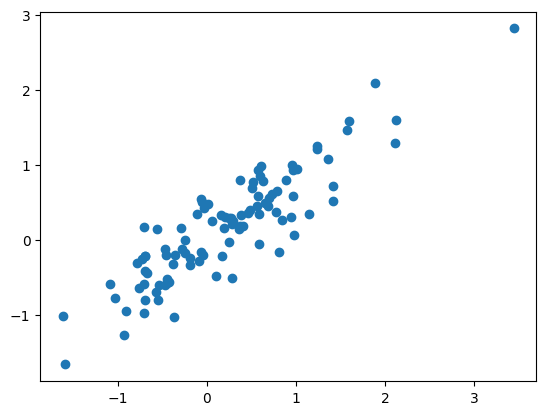

In [49]:
import matplotlib.pyplot as plt
inputs_np = inputs.to("cpu").numpy().round(3)
outputs_np = outputs.to("cpu").numpy().round(3)
inputs_0 = inputs_np[0]
outputs_0 = outputs_np[0]
mask = inputs_0<5

# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.scatter(inputs_0[mask][:100], outputs_0[mask][:100])

In [35]:
class Encoder(torch.nn.Module):
    def __init__(self, h_sizes, dropout=0.2):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(h_sizes[0], h_sizes[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[1], h_sizes[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[2], h_sizes[3])
        )
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [37]:
path  ="../models/cell_encoder.pt"
torch.save(ae.encoder.state_dict(), path)

encoder = Encoder([xi.shape[1],param_dict["first_layer"],512,256], dropout=0)
encoder.encoder.load_state_dict(torch.load(path))
encoder.eval()

with torch.no_grad():
    for i, data in enumerate(train_dl_drug):
        encoder = encoder.to(device)
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = encoder(inputs)
with open("output_encoder_cell.txt", mode="w") as f: 
    [f.write(
        str(outputs[0][i].to("cpu").numpy().round(3))+"   "+
        str(inputs[0][i].to("cpu").numpy().round(3))+"\n") for i in range(len(outputs[0]))]